In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
from itertools import compress
import calfews_src
# from read_hdf5_output import get_results_sensitivity_number
from calfews_src import *
from calfews_src.visualizer import Visualizer
from calfews_src.util import *
import seaborn as sns

from make_financial_data_km import analyze_correlation_between_pumping_and_revenue


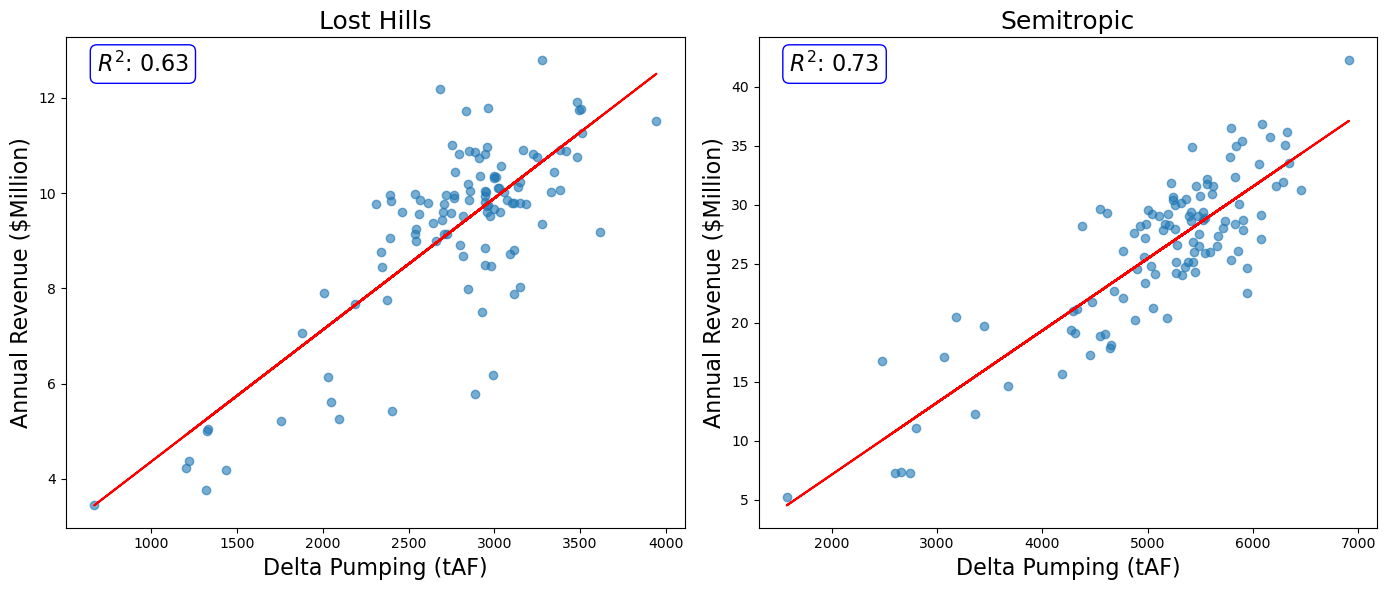

In [ ]:
# Lost hills
output_file_losthills = "results/110_year/results.hdf5"
datDaily_losthills = get_results_sensitivity_number_outside_model(output_file_losthills, '')
daily_pump_data_losthills = datDaily_losthills.loc[:, ['delta_HRO_pump', 'delta_TRP_pump']]
daily_pump_data_losthills['total_pump'] = daily_pump_data_losthills['delta_HRO_pump']  # Losthills only uses HRO
yearly_pump_data_losthills = daily_pump_data_losthills.resample('AS-OCT').sum()
yearly_pump_data_losthills = yearly_pump_data_losthills['total_pump']

revenue_file_losthills = 'calfews_src/postprocess/losthills_daily_revenue_110.csv'
losthills_daily_revenue = pd.read_csv(revenue_file_losthills, index_col=0, parse_dates=True)
losthills_Y_revenue = losthills_daily_revenue.resample('AS-OCT').last()
aligned_data_losthills = losthills_Y_revenue.join(yearly_pump_data_losthills, how='inner')
x_losthills = aligned_data_losthills['total_pump']
y_losthills = aligned_data_losthills.iloc[:, 0]

#  Semitropic
revenue_file_semitropic = 'calfews_src/postprocess/semitropic_daily_revenue_110.csv'
semitropic_daily_revenue = pd.read_csv(revenue_file_semitropic, index_col=0, parse_dates=True)
daily_pump_data_semitropic = datDaily_losthills.copy()
daily_pump_data_semitropic['total_pump'] = daily_pump_data_semitropic['delta_HRO_pump'] + daily_pump_data_semitropic['delta_TRP_pump']
yearly_pump_data_semitropic = daily_pump_data_semitropic.resample('AS-OCT').sum()
yearly_pump_data_semitropic = yearly_pump_data_semitropic['total_pump']
semitropic_Y_revenue = semitropic_daily_revenue.resample('AS-OCT').last()
aligned_data_semitropic = semitropic_Y_revenue.join(yearly_pump_data_semitropic, how='inner')
x_semitropic = aligned_data_semitropic['total_pump']
y_semitropic = aligned_data_semitropic.iloc[:, 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
font_size = 16

# Plot Lost Hills data
slope_losthills, intercept_losthills = np.polyfit(x_losthills, y_losthills, 1)
line_losthills = slope_losthills * x_losthills + intercept_losthills
ss_res_losthills = np.sum((y_losthills - line_losthills) ** 2)
ss_tot_losthills = np.sum((y_losthills - np.mean(y_losthills)) ** 2)
r_squared_losthills = 1 - (ss_res_losthills / ss_tot_losthills)

ax1.scatter(x_losthills, y_losthills, alpha=0.6)
ax1.plot(x_losthills, line_losthills, 'r-', label=f'Fit line: y={slope_losthills:.2f}x + {intercept_losthills:.2f}')
ax1.set_title("Lost Hills", fontsize=18)
ax1.set_xlabel("Delta Pumping (tAF)", fontsize=font_size)
ax1.set_ylabel("Annual Revenue ($Million)", fontsize=font_size)
ax1.grid(False)
ax1.annotate(f"$R^2$: {r_squared_losthills:.2f}", xy=(0.05, 0.93), xycoords='axes fraction',
             fontsize=font_size, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

# Plot Semitropic data
slope_semitropic, intercept_semitropic = np.polyfit(x_semitropic, y_semitropic, 1)
line_semitropic = slope_semitropic * x_semitropic + intercept_semitropic
ss_res_semitropic = np.sum((y_semitropic - line_semitropic) ** 2)
ss_tot_semitropic = np.sum((y_semitropic - np.mean(y_semitropic)) ** 2)
r_squared_semitropic = 1 - (ss_res_semitropic / ss_tot_semitropic)

ax2.scatter(x_semitropic, y_semitropic, alpha=0.6)
ax2.plot(x_semitropic, line_semitropic, 'r-', label=f'Fit line: y={slope_semitropic:.2f}x + {intercept_semitropic:.2f}')
ax2.set_title("Semitropic", fontsize=18)
ax2.set_xlabel("Delta Pumping (tAF)", fontsize=font_size)
ax2.set_ylabel("Annual Revenue ($Million)", fontsize=font_size)
ax2.grid(False)
ax2.annotate(f"$R^2$: {r_squared_semitropic:.2f}", xy=(0.05, 0.93), xycoords='axes fraction',
             fontsize=font_size, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

plt.tight_layout()
plt.savefig(f"plots/basis_risk_110yr.png")
plt.show()

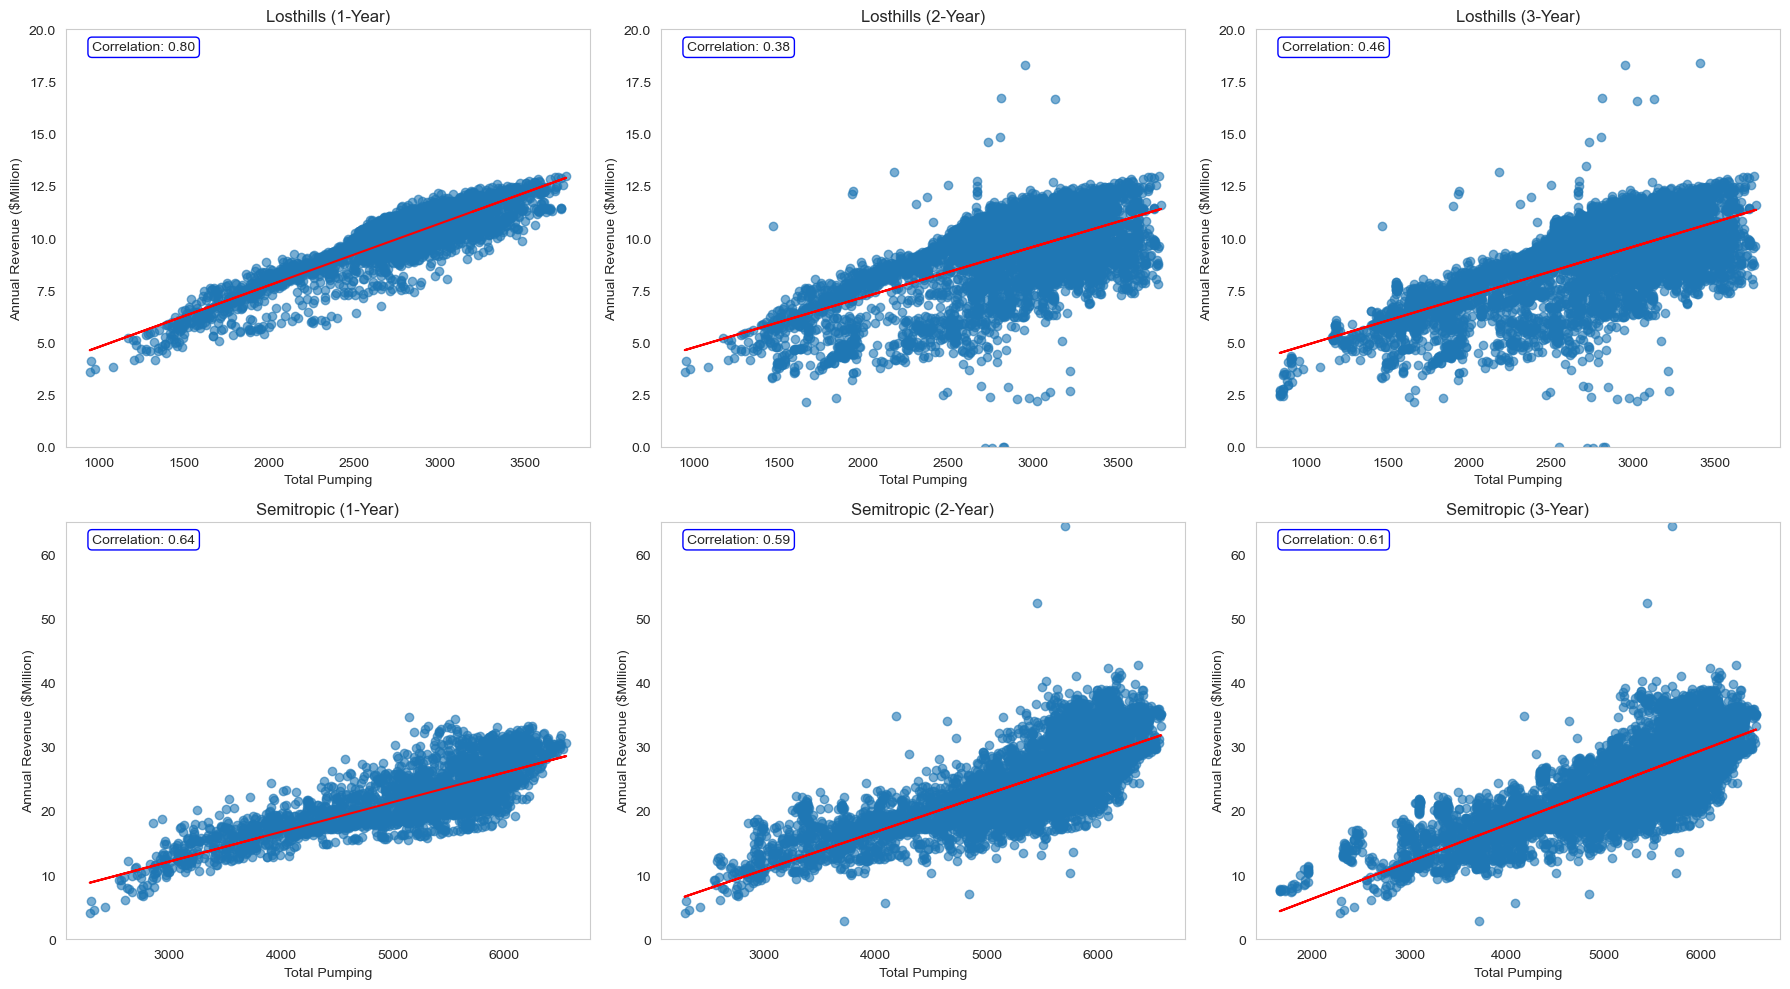

In [6]:

fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 districts x 3 years

districts = ['losthills', 'semitropic']
years_to_include_opts = [1, 2, 3]

for i, district in enumerate(districts):
    for j, years_to_include in enumerate(years_to_include_opts):
        x, y = analyze_correlation_between_pumping_and_revenue(district, years_to_include)

        slope, intercept = np.polyfit(x, y, 1)
        line = slope * x + intercept

        ax = axs[i, j]
        ax.scatter(x, y, alpha=0.6)
        ax.plot(x, line, 'r-', label=f'y={slope:.2f}x + {intercept:.2f}')
        ax.set_title(f"{district.capitalize()} ({years_to_include}-Year)")
        ax.set_xlabel("Total Pumping")
        ax.set_ylabel("Annual Revenue ($Million)")
        ax.grid(False)

        # Set specific y limits for each district
        if district == 'losthills':
            ax.set_ylim(0, 20)
        elif district == 'semitropic':
            ax.set_ylim(0, 65)

        corr_coef = np.corrcoef(x, y)[0, 1]
        r_squared = corr_coef ** 2
        ax.annotate(f"Correlation: {r_squared:.2f}", xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

plt.tight_layout()
plt.savefig("plots/comparison_contractPeriod.png")
plt.show()

In [5]:
y_max

64.30068602154333

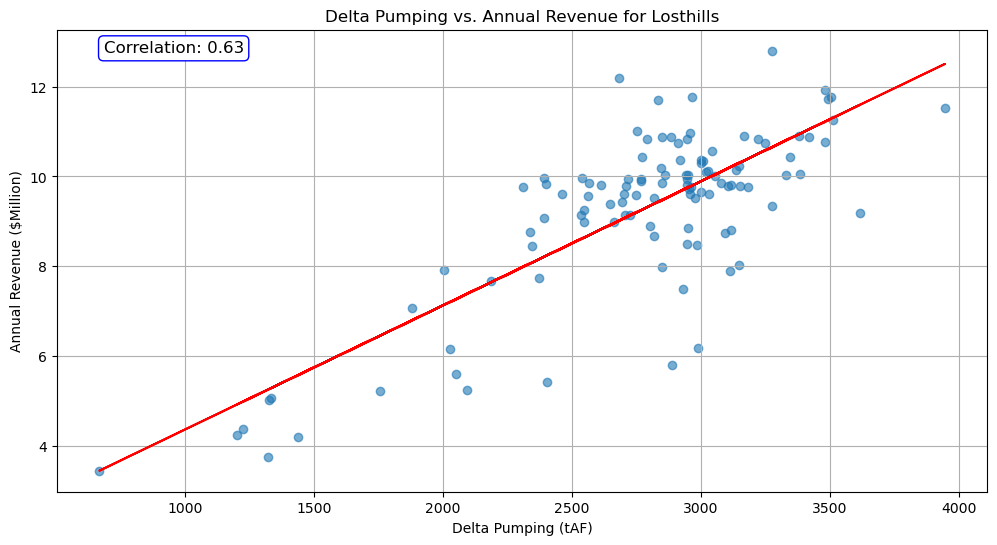

In [15]:
#######basis risk for lost Hills irrigation district###########################
###############################################################################
# output_folder = "results/1_2024/"
output_folder = "results/110_year/"
# output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
datDaily = get_results_sensitivity_number_outside_model(output_file, '')
daily_pump_data = datDaily.loc[:,['delta_HRO_pump', 'delta_TRP_pump']]
daily_pump_data['total_pump'] = daily_pump_data['delta_HRO_pump']   # only get water from SWP (HRO)
yearly_pump_data = daily_pump_data.resample('AS-OCT').sum()
yearly_pump_data = yearly_pump_data['total_pump']

# revenue_file = 'calfews_src/postprocess/losthills_daily_revenue_syn_1_2024.csv'
revenue_file = 'calfews_src/postprocess/losthills_daily_revenue_110.csv'
# revenue_file = 'calfews_src/postprocess/losthills_daily_revenue.csv'
losthills_daily_revenue = pd.read_csv(revenue_file, index_col=0, parse_dates=True)
losthills_Y_revenue = losthills_daily_revenue.resample('AS-OCT').last()
# losthills_Y_revenue
aligned_data = losthills_Y_revenue.join(yearly_pump_data, how='inner')
x = aligned_data['total_pump']
y = aligned_data.iloc[:, 0]

# Calculate the linear fit
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept  # This is the line equation

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.6,)
plt.plot(x, line, 'r-', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
plt.title(f"Delta Pumping vs. Annual Revenue for Losthills")
plt.xlabel("Delta Pumping (tAF)")
plt.ylabel("Annual Revenue ($Million)")
plt.grid(True)
# plt.legend()


#use numpy to calculate the correlation coefficient as a visual indicator
corr_coef = np.corrcoef(x, y)[0, 1]
r_squared = corr_coef ** 2
plt.annotate(f"Correlation: {r_squared:.2f}", xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

plt.show()

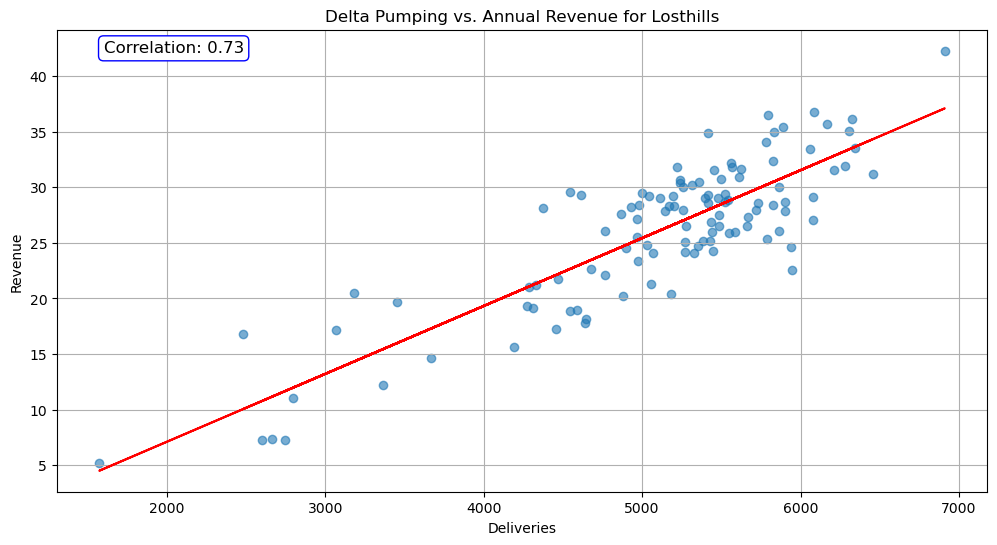

In [16]:
revenue_file = 'calfews_src/postprocess/semitropic_daily_revenue_110.csv'
semitropic_daily_revenue = pd.read_csv(revenue_file, index_col=0, parse_dates=True)
semitropic_Y_revenue = semitropic_daily_revenue.resample('AS-OCT').last()

daily_pump_data['total_pump'] = daily_pump_data['delta_HRO_pump'] + daily_pump_data['delta_TRP_pump']    # only get water from SWP (HRO)
yearly_pump_data = daily_pump_data.resample('AS-OCT').sum()
yearly_pump_data = yearly_pump_data['total_pump']
aligned_data = semitropic_Y_revenue.join(yearly_pump_data, how='inner')
x = aligned_data['total_pump']
y = aligned_data.iloc[:, 0]

# Calculate the linear fit
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept  # This is the line equation

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.6,)
plt.plot(x, line, 'r-', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
plt.title(f"Delta Pumping vs. Annual Revenue for Losthills")
plt.xlabel("Deliveries")
plt.ylabel("Revenue")
plt.grid(True)
# plt.legend()


# You can use numpy to calculate the correlation coefficient as a visual indicator
corr_coef = np.corrcoef(x, y)[0, 1]
r_squared = corr_coef ** 2
plt.annotate(f"Correlation: {r_squared:.2f}", xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

plt.show()

(array([ 1.,  0.,  0.,  2.,  3.,  1.,  2.,  2.,  0.,  1.,  7.,  9., 10.,
        17., 24., 13., 11.,  6.,  1.,  1.]),
 array([1573.35118775, 1840.18643345, 2107.02167915, 2373.85692485,
        2640.69217056, 2907.52741626, 3174.36266196, 3441.19790766,
        3708.03315337, 3974.86839907, 4241.70364477, 4508.53889047,
        4775.37413618, 5042.20938188, 5309.04462758, 5575.87987328,
        5842.71511898, 6109.55036469, 6376.38561039, 6643.22085609,
        6910.05610179]),
 <BarContainer object of 20 artists>)

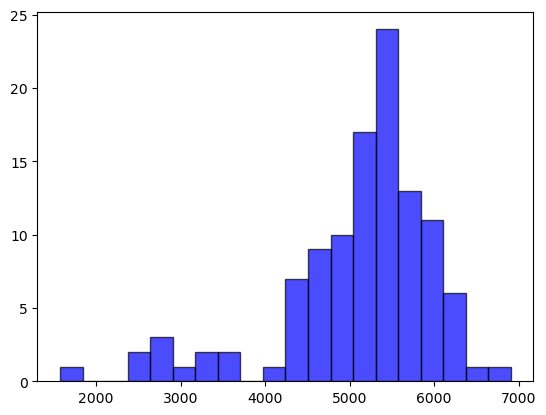

In [5]:
plt.hist(aligned_data['total_pump'], bins=20, color='blue', edgecolor='black', alpha=0.7)